<a href="https://colab.research.google.com/github/Priyo-prog/Deep-Learning-with-Tensorflow/blob/main/Transfer%20Learning%20with%20Tensorflow/transfer_learning_with_tensorflow_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning with TensorFlow part 2: Fine Tuning**

In [1]:
# Check the GPU we are using 
!nvidia-smi

Tue Feb 22 03:33:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Getting the helper function

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-02-22 03:33:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-22 03:33:02 (80.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import the helper functions we are going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Get the data

This time we are going to see how we can use the pretrained models within 'tf.keras.applications' and apply them to our problem

In [4]:
# Get the 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-02-22 03:33:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.128, 209.85.145.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   173MB/s    in 0.9s    

2022-02-22 03:33:06 (173 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [6]:
# Create training and test directories paths
train_dir = "10_food_classes_10_percent/train"
test_data = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_data,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of batch of data
for images, labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[2.19841827e+02 1.08841835e+02 1.17841835e+02]
   [2.23168365e+02 1.13168365e+02 1.22168365e+02]
   [2.19785721e+02 1.10428574e+02 1.21214287e+02]
   ...
   [2.27285721e+02 2.23285721e+02 2.24285721e+02]
   [2.26642853e+02 2.22642853e+02 2.23642853e+02]
   [2.26642853e+02 2.22642853e+02 2.23642853e+02]]

  [[2.23091843e+02 1.11091835e+02 1.23091835e+02]
   [2.26642868e+02 1.14642853e+02 1.26642853e+02]
   [2.20173462e+02 1.10602036e+02 1.22030609e+02]
   ...
   [2.26086731e+02 2.22086731e+02 2.23086731e+02]
   [2.25137756e+02 2.21137756e+02 2.22137756e+02]
   [2.24142853e+02 2.20142853e+02 2.21142853e+02]]

  [[2.21576523e+02 1.06576530e+02 1.21576530e+02]
   [2.21387756e+02 1.09341835e+02 1.23357140e+02]
   [2.21000000e+02 1.11000000e+02 1.24000000e+02]
   ...
   [2.26214279e+02 2.19571426e+02 2.19785721e+02]
   [2.26443878e+02 2.19801025e+02 2.20015305e+02]
   [2.26642853e+02 2.20000000e+02 2.20214279e+02]]

  ...

  [[2.38928619e+02 2.17357147e+02 2.19142883e+02]
   [2

## Build Transfer Learning model using Functional API

The Sequential API is straight forward, it runs our layer in sequential order

But the Functional API gives us more flexibility with our models :- 

[Tensorflow Keras Functional API](https://www.tensorflow.org/guide/keras/functional)

In [10]:
# 1. Create bas model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs in our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't need to for EfficientNet)
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save it's history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

16719872/16705208 [==============================] - 1s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220222-033323
Epoch 1/5
24/24 [==============================] - 33s 462ms/step - loss: 1.9121 - accuracy: 0.4053 - val_loss: 1.3772 - val_accuracy: 0.6924
Epoch 2/5
24/24 [==============================] - 7s 276ms/step - loss: 1.1591 - accuracy: 0.7560 - val_loss: 0.9739 - val_accuracy: 0.7763
Epoch 3/5
24/24 [==============================] - 9s 361ms/step - loss: 0.8523 - accuracy: 0.8040 - val_loss: 0.7841 - val_accuracy: 0.8174
Epoch 4/5
24/24 [==============================] - 7s 272ms/step - loss: 0.6979 - accuracy: 0.8440 - val_loss: 0.6884 - val_accuracy: 0.8141
Epoch 5/5
24/24 [==============================] - 7s 272ms/step - loss: 0.5892 - accuracy: 0.8653 - val_loss: 0.6335 - val_accuracy: 0.8191


In [11]:
# Evaluate on full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 12s 140ms/step - loss: 0.6107 - accuracy: 0.8420


[0.6106657981872559, 0.8420000076293945]

In [12]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [13]:
# Summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


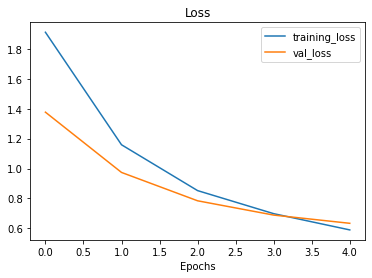

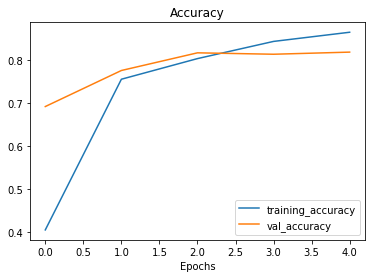

In [14]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Get a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer

We have a tensor after our model goes through 'base model' of 
shape(None, 7, 7, 1280) 

But when it passes through GlobalAveragePooling2D, it turns into 
shape(None, 1280)..

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it
to GlobalAveragePooling2D.


In [15]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n{input_tensor}\n")

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]



In [16]:
# pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor) # Passing the input_tensor after the layer
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [17]:
# Check the shapes of different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of the global average pooled 2D tensor : {global_average_pooled_tensor}")

Shape of input tensor: (1, 4, 4, 3)
Shape of the global average pooled 2D tensor : [[-0.09368646 -0.45840448 -0.2885598 ]]


In [18]:
# Let's replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Feature Vector

**What is a feature vector?**

Ans : A feature vector is a learned representation of the input data(a compressed form of the input data based on how model see's it)

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it goes with **1%** of the training data... how about we setup a bunch of experiments to find out:

1. 'model_1' - use feature extraction transfer learning with 1% of data with data augmentation

2. 'model_2' - use feature extraction transfer learning with 10% of the training data with data augmentation 

3. 'model_3' - use **fine-tuning** transfer learning on 10% of the training data with data augmentation.

4. 'model_4' - use fine-tuning transfer learning on 100% of the training data with data augmentation. 


Note: throught all experiments the same test dataset will be used to evaluate our model.... this ensure consistency across evaluation metrics.

In [36]:
# Download and unzip the data -  preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2022-02-22 04:02:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.1.128, 108.177.121.128, 142.250.103.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   211MB/s    in 0.6s    

2022-02-22 04:02:04 (211 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [37]:
# Create train and test dirs 
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [38]:
# How many images are we working with ?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There a

In [39]:
# Set up the data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


* Adding data augmentation right into the model

   To add the data augmentation right into our models, we can use the layers   inside:
   * tf.keras.layers.experimental.preprocessing()

* Benefits of in-layer data augmentation

There are two important points to be aware of in this case:

* Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.

* When you export your model using **model.save**, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.




In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Create data augmentation stage with horizontal flipping, rotation, zooms etc..
data_augmentation = Sequential([
 preprocessing.RandomFlip("horizontal"),
 preprocessing.RandomRotation(0.2),
 preprocessing.RandomZoom(0.2),
 preprocessing.RandomHeight(0.2),
 preprocessing.RandomWidth(0.2),
 # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's having rescaling built-in                                      
], name="data_augmentation")

## Visualize out data augmentation layer

In [47]:
# View a random image and compare it to it's augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
print(target_dir)

10_food_classes_1_percent/train/ramen


In [48]:
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(random_image_path)

10_food_classes_1_percent/train/ramen/3362012.jpg


[[[102  84  38]
  [107  86  41]
  [106  85  38]
  ...
  [ 39  32  22]
  [ 31  27  18]
  [ 25  21  12]]

 [[108  90  44]
  [111  90  43]
  [105  84  37]
  ...
  [ 40  33  23]
  [ 38  34  25]
  [ 37  33  24]]

 [[117  99  51]
  [120  99  52]
  [114  94  44]
  ...
  [ 39  32  22]
  [ 41  34  26]
  [ 44  37  29]]

 ...

 [[ 49  31   7]
  [ 46  28   4]
  [ 41  23   0]
  ...
  [148 131  87]
  [149 132  88]
  [155 138  95]]

 [[ 45  27   3]
  [ 45  27   3]
  [ 45  27   3]
  ...
  [142 125  82]
  [147 130  87]
  [151 133  93]]

 [[ 38  20   0]
  [ 40  22   0]
  [ 45  27   3]
  ...
  [148 131  88]
  [149 131  91]
  [143 125  85]]]


Text(0.5, 1.0, 'Original random image from class : ramen')

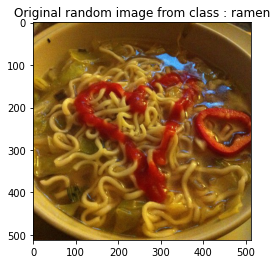

In [49]:
# Visualize the random image
img = mpimg.imread(random_image_path)
print(img)
plt.imshow(img)
plt.title(f'Original random image from class : {target_class}')
#plt.axis(emit=False)

Text(0.5, 1.0, 'Augmented random image from class: ramen')

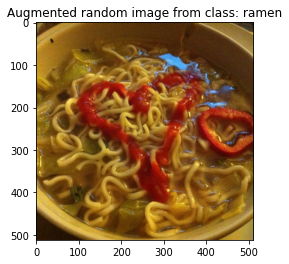

In [50]:
# Now let's plot our augmented image
augmented_image = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_image)/255.) #  
plt.title(f"Augmented random image from class: {target_class}")
#plt.axis(False)

## Model 1 : Feature extraction transfer learning on 1% of the data with data augmentation (only 7 images per class for training)

In [28]:
#Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)

# Create the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # Keeping the transfer learning base model intact

# Create the input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in the data augmentation Sequential model as layer
x = data_augmentation(inputs)

# Give base model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) # passing the input to the model api class

# Puta  dense layer on as the output 
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learninig",
                                                                       experiment_name="1_percent_data_aug")]) # from helper functions                                                                       
                                                                       

Saving TensorBoard log files to: transfer_learninig/1_percent_data_aug/20220222-033522
Epoch 1/5
3/3 [==============================] - 18s 4s/step - loss: 2.3809 - accuracy: 0.1429 - val_loss: 2.2262 - val_accuracy: 0.2089
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1669 - accuracy: 0.2571 - val_loss: 2.1011 - val_accuracy: 0.2632
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9616 - accuracy: 0.4571 - val_loss: 1.9938 - val_accuracy: 0.3289
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.8813 - accuracy: 0.5429 - val_loss: 1.9099 - val_accuracy: 0.4062
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.6144 - accuracy: 0.6714 - val_loss: 1.8148 - val_accuracy: 0.4737


In [29]:
# Check out the model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [30]:
# Evaluate the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 11s 135ms/step - loss: 1.8176 - accuracy: 0.4600


[1.8176429271697998, 0.46000000834465027]

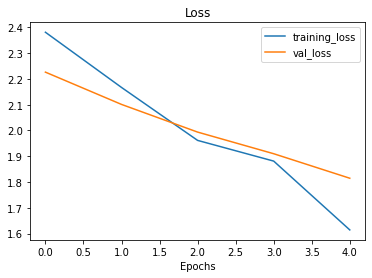

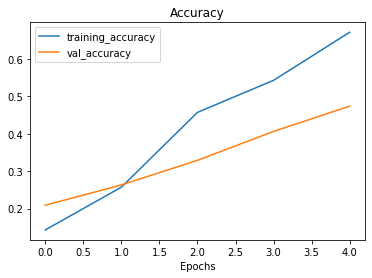

In [31]:
# How do the model with 1% of the training data and data augmentation loss curves look?
plot_loss_curves(history_1_percent)


## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation

In [33]:
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
#unzip_data(10_food_classes_10_percent)

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [34]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [51]:
# Create Model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build Data Augmentation Layer
data_augmentation = Sequential([
 preprocessing.RandomFlip("horizontal"),
 preprocessing.RandomHeight(0.2),
 preprocessing.RandomWidth(0.2),
 preprocessing.RandomZoom(0.2),
 preprocessing.RandomRotation(0.2),
 #preprocessing.Rescaling(1./255) # if you're using a model such as ResNet50V2, you'll need to rescale your data, efficientnet has rescaling built-in                                
], name="data_augmentation")

# Setup the input shape of our model
input_shape = (224,224,3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# 